NGTS-10 had a failed observation, do we need to re observe?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/'

In [4]:
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo36010_x1d.fits']

Note oeoo36010 has poor slit alignment

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits
528.6959
0.80208945


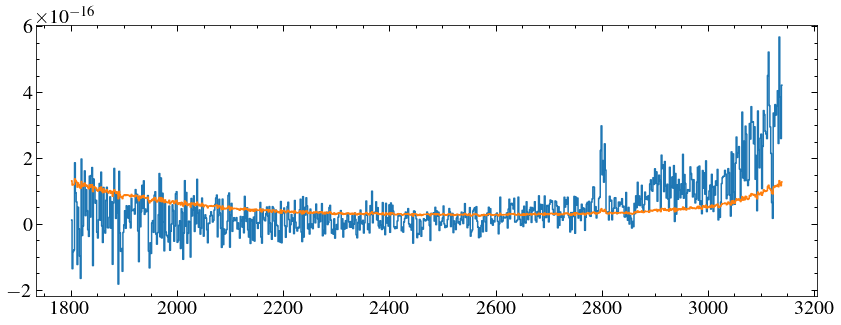

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits
528.76044
0.8611564


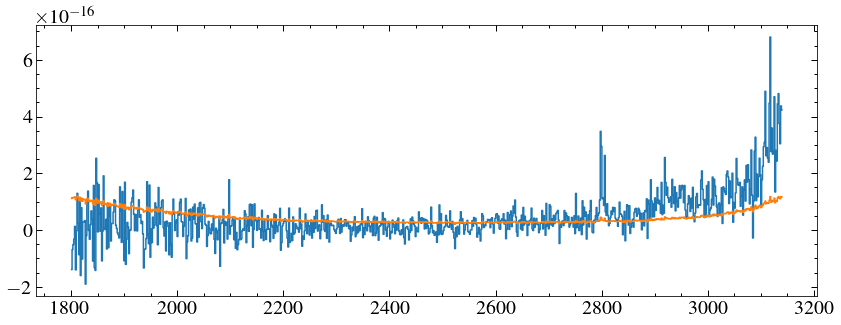

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits
528.84503
0.767719


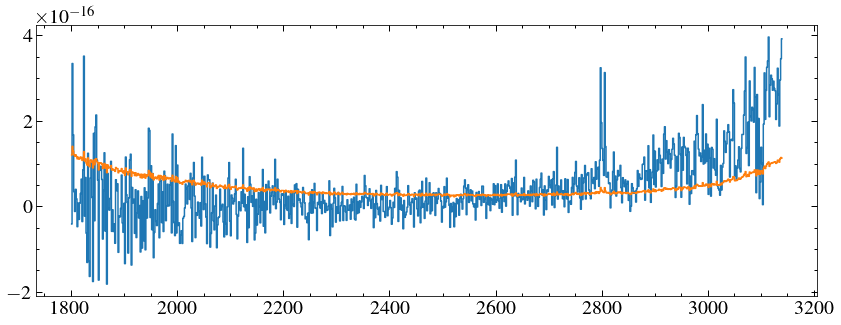

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits
528.88574
0.7592693


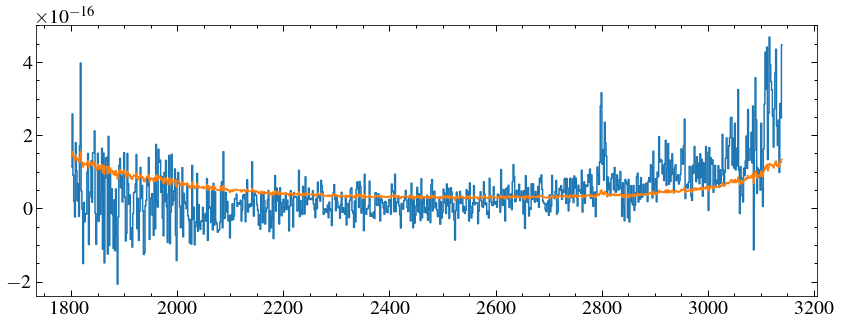

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits
528.66766
0.75189805


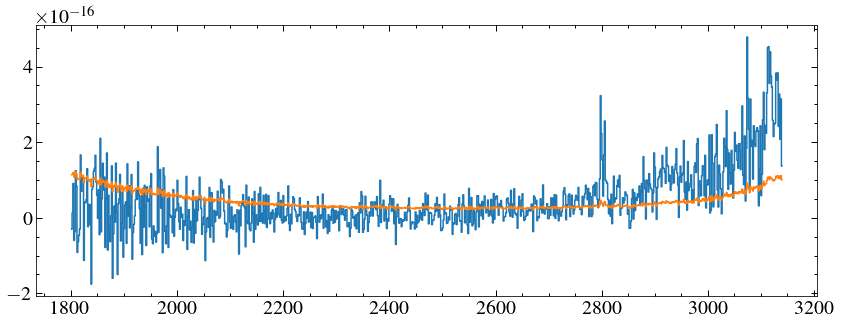

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits
528.61176
0.914252


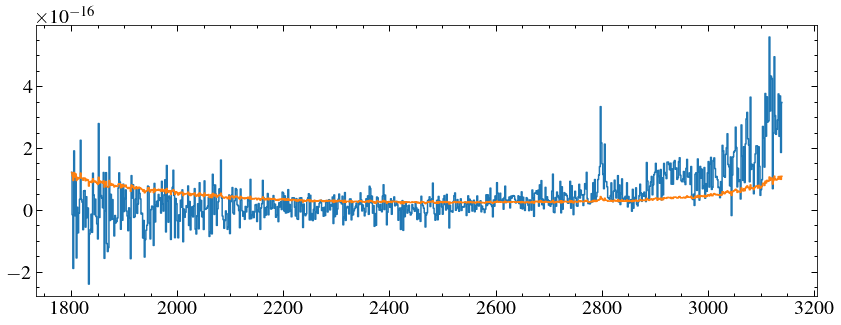

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits
528.526
0.89824116


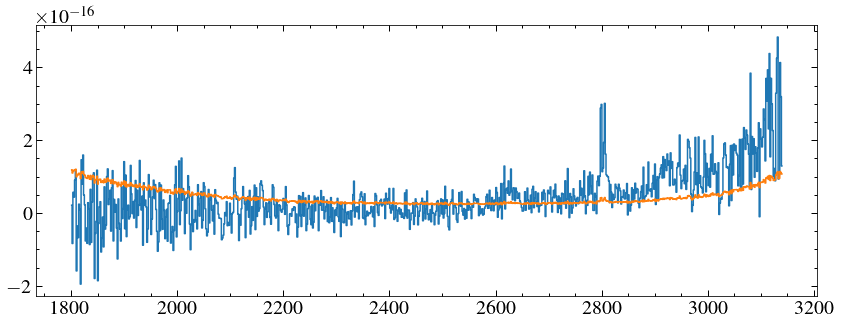

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo36010_x1d.fits
530.57764
0.74627763


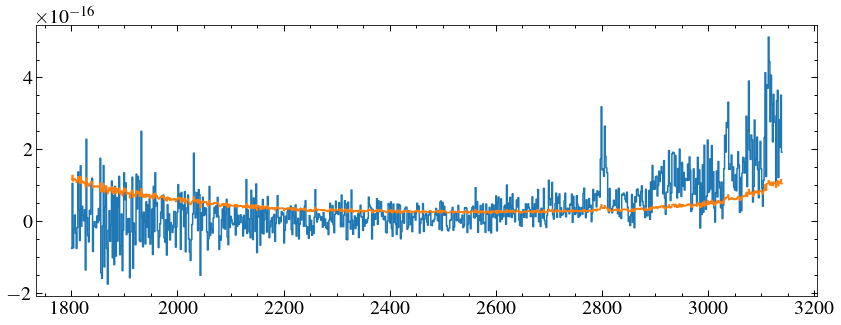

In [67]:
for x in x1ds:
    print(x)
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = (w > 1800) & (w < 3140)
    print(data['A2CENTER'])
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    print(np.median(f/e))
    plt.show()

In [112]:
fits.getheader(x,0)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS file may contain extensions               
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2022-04-27' / date this file was written (yyyy-mm-dd)                
NEXTEND =                    1 / Number of extensions                           
FILENAME= 'oeoo36010_x1d.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

In [21]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [148]:
fall = []
eall = []


for x in x1ds:
    print(x)
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    fall.append(f)
    eall.append(e)
wn = w
fn, en = spectra_adder(np.array(fall), np.array(eall))


/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo36010_x1d.fits


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


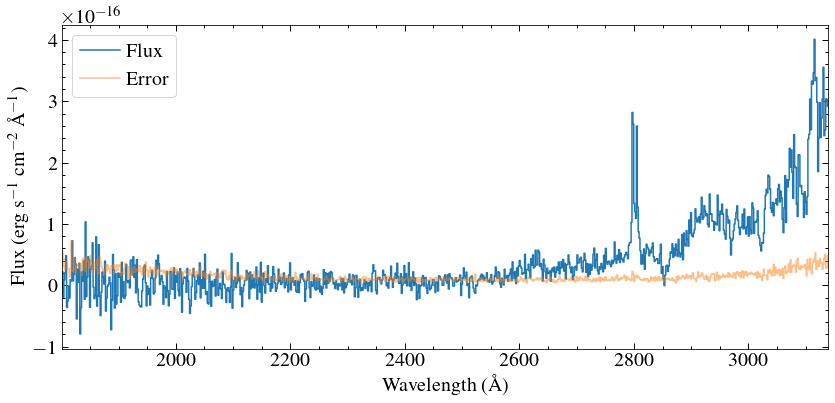

In [65]:
plt.figure(figsize= (12, 6))
mask = (wn > 1800) & (wn < 3140)
plt.step(wn[mask], fn[mask], where='mid', label='Flux')
plt.step(wn[mask], en[mask], where='mid', alpha=0.5, label='Error')

plt.legend(frameon=True)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlim(1801, 3139)
plt.tight_layout()
plt.savefig('plots/ngts-10_g230l_coadd.png', facecolor='w')
plt.savefig('plots/ngts-10_g230l_coadd.pdf')

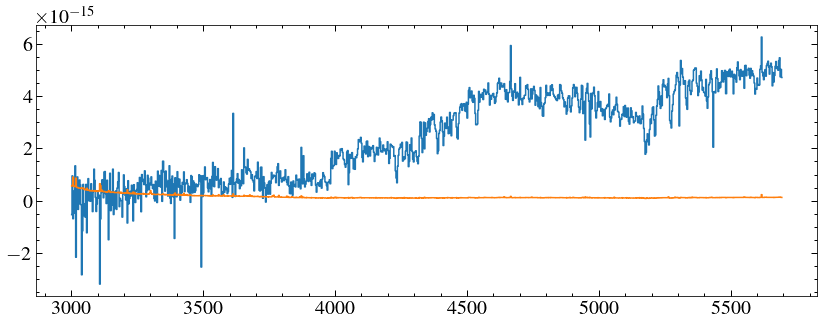

In [91]:
odata = fits.getdata('{}'.format(glob.glob('{}*sx1.fits'.format(path))[0]))[0]
wo, fo, eo = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
mask = (wo > 3000) & (wo <3349) | (wo > 3350) & (wo < 5324) | (wo > 5325) & (wo < 5480) | (wo > 5482) & (wo < 5695)
wo, fo, eo = wo[mask], fo[mask], eo[mask] 
plt.step(wo, fo, where='mid')
plt.step(wo, eo, where='mid')

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


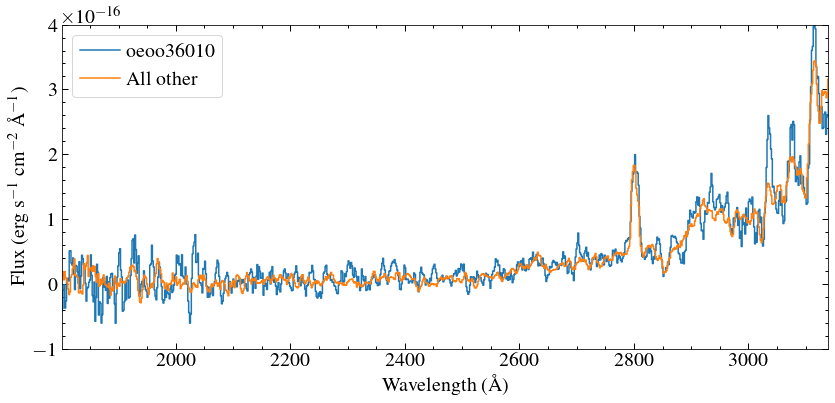

In [66]:
plt.figure(figsize= (12, 6))

data = fits.getdata(x1ds[-1], 1)[0]
root = fits.getheader(x1ds[-1])['ROOTNAME']
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
# plt.step(w, f)
fi = convolve(f,Box1DKernel(5))
plt.step(w, fi, where='mid', label=root)

for x in x1ds[:-1]:
    print(x)
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    fall.append(f)
    eall.append(e)

f, e = spectra_adder(np.array(fall), np.array(eall))
fi = convolve(f,Box1DKernel(5))
plt.step(w, fi, where='mid', label = 'All other')
plt.legend(frameon=True)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.ylim(-1e-16, 4e-16)
plt.xlim(1801, 3139)
plt.tight_layout()
plt.savefig('plots/ngts-10_oeoo36010_comp.png', facecolor='w')
plt.savefig('plots/ngts-10_oeoo36010_comp.pdf')

(1e-17, 1.154757691624734e-14)

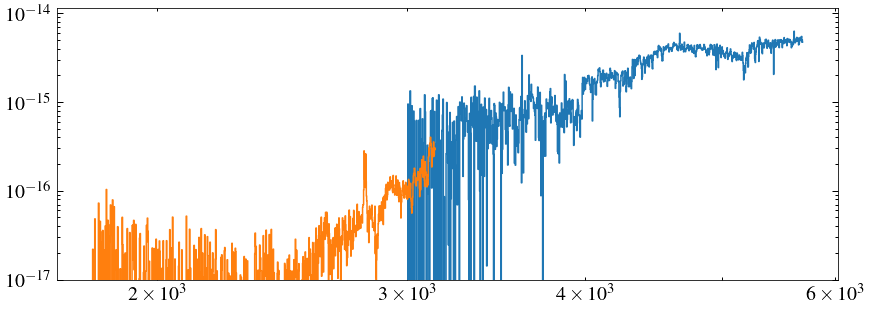

In [95]:
plt.step(wo, fo, where='mid')
mask = (wn > 1800) & (wn < 3140)
plt.step(wn[mask], fn[mask], where='mid', label='Flux')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-17)

Can we detect the planet? doubt it but fun to try.

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34010_x1d.fits
[1.18572320e-17 1.87576008e-01 1.02868569e-16 1.30741310e+00
 4.44621265e+03]
298.16603073280453 km / s 20.109725962934817 km / s 20.10972596293476 km / s


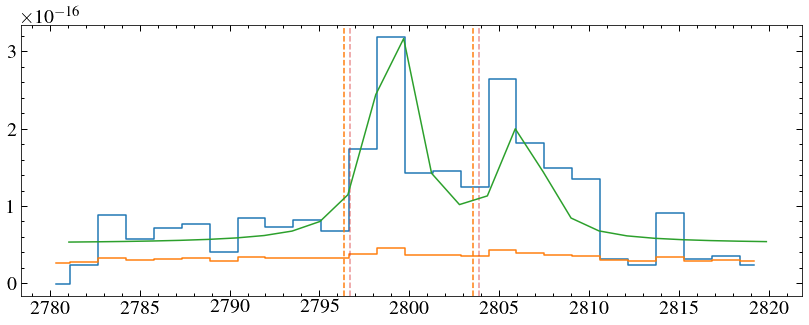

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34020_x1d.fits
[7.36806468e-18 6.92362965e-02 7.34736250e-17 4.81473681e-01
 7.09763778e+03]
250.4577784280865 km / s 7.422713419989691 km / s 7.422713419923127 km / s


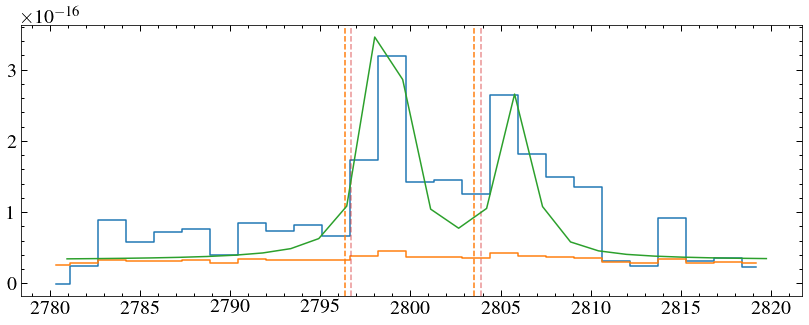

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34030_x1d.fits
[7.63471795e-18 9.26873130e-02 1.82563380e-16 6.03956174e-01
 4.61696775e+01]
238.32850900191224 km / s 9.936859660698474 km / s 9.936859660698474 km / s


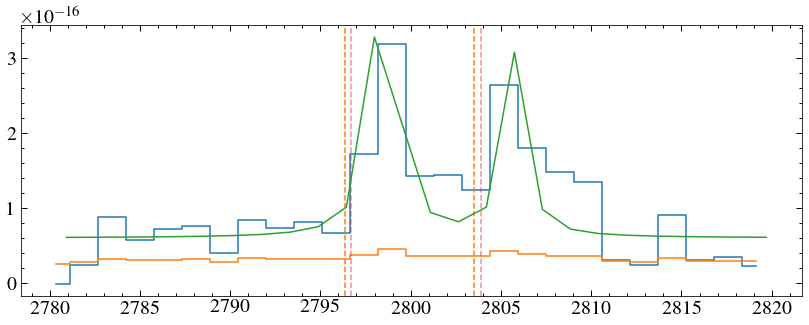

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo34040_x1d.fits
[1.11435400e-17 1.48075065e-01 9.00678788e-17 1.07163062e+00
 3.48351176e+04]
274.5886747320863 km / s 15.874892581508107 km / s 15.874892581441486 km / s


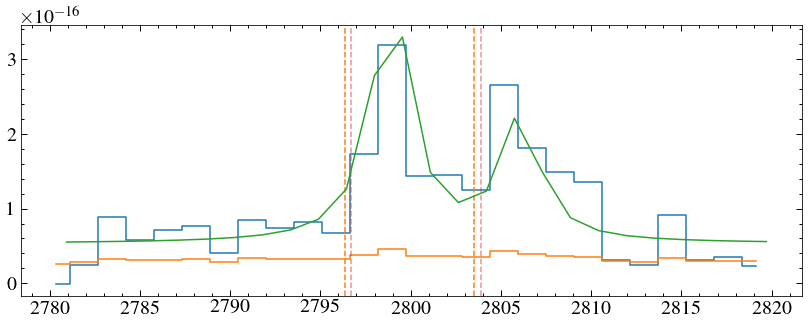

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35010_x1d.fits
[1.06053426e-17 1.39444757e-01 1.00084055e-16 8.84899659e-01
 4.91923352e+03]
249.53765958299428 km / s 14.949650951553224 km / s 14.949650951486689 km / s


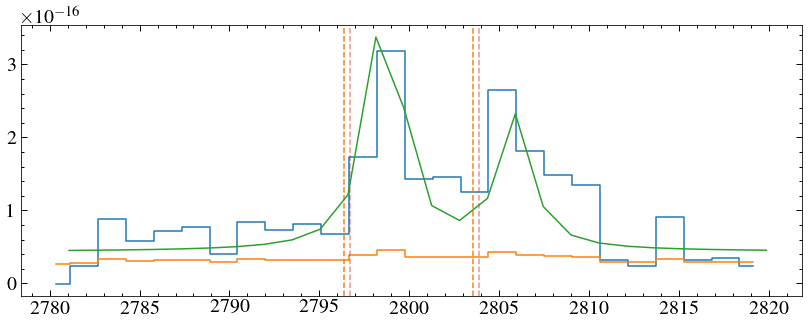

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35020_x1d.fits
[8.28036596e-18 1.45574649e-01 8.35102751e-17 9.53595352e-01
 5.59332477e+01]
233.13199842136552 km / s 15.60682697393537 km / s 15.60682697393537 km / s


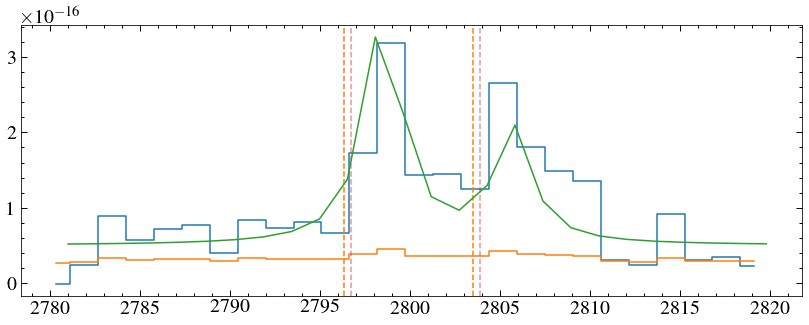

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo35030_x1d.fits
[1.08714285e-17 1.05310813e-01 1.05899564e-16 7.70056597e-01
 8.66587087e+02]
267.08934905967226 km / s 11.290205074921431 km / s 11.290205074987966 km / s


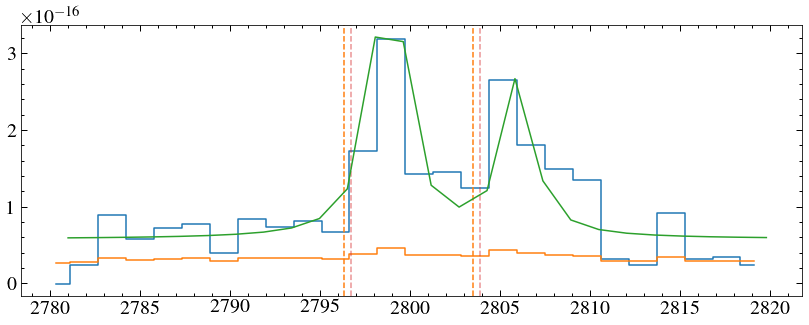

/media/david/2tb_ext_hd/hddata/meats/hst/ngts-10/oeoo36010_x1d.fits
[1.22436038e-17 2.52517653e-01 1.18625508e-16 1.71732857e+00
 1.01031384e+04]
257.2701883424372 km / s 27.072016603448475 km / s 27.07201660344856 km / s


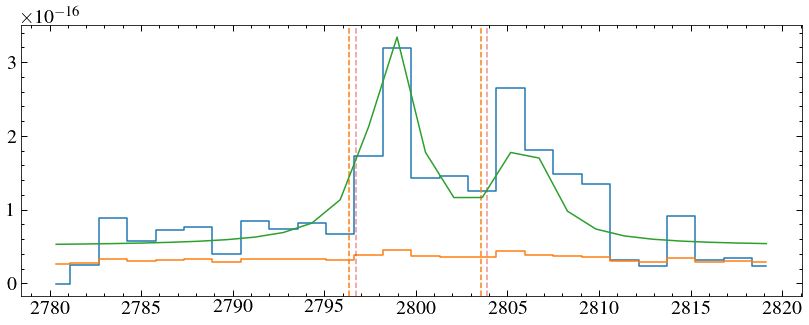

In [147]:
fitter = fitting.LevMarLSQFitter()

mjds = []
dvs = []
dveus = []
dvels = []

mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]

for i, x in enumerate(x1ds):
    print(x)
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x)
    
    mjds.append((hdr['TEXPSTRT']+hdr['TEXPEND'])/2)
    
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    
    mask = (w > 2780) & (w < 2820)
    wl, fl, el = w[mask], f[mask], e[mask]



    plt.step(wn, fn, where='mid')
    plt.step(wn, en, where='mid')
    # plt.plot(wp, fp)
    # plt.yscale('log')
    [plt.axvline(line, ls='--', c='C1') for line in mg2]

    lines = np.copy(mg2)

    mod = models.Const1D(0)#, fixed=dict(amplitude=True))
    for line in lines:
        line_guess = (+39*u.km/u.s).to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
        # mod = mod+  models.Gaussian1D(amplitude=np.max(fn)/2, mean = line_guess, stddev=1)
        mod = mod + models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fn), fwhm_G=1, fwhm_L=1)#, bounds=dict(amplitude_L=[0, 1]))
        # plt.axvline(line, ls='--', c='C2', alpha =0.5)
        plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)

    def tiedfunc0(mod):
        mean = mod.mean_1.value+np.diff(lines)
        return mean

    def tiedfunc1(mod):
        x_0 = mod.x_0_1.value+np.diff(lines)
        # fwhm_G = mod.fwhm_G_1.value
        return x_0

    def tiedfwhmg(mod):
        fwhm_G = mod.fwhm_G_1.value
        return fwhm_G

    def tiedfwhml(mod):
        fwhm_L = mod.fwhm_L_1.value
        return fwhm_L

    def tiedamp(mod):
        amplitude = mod.amplitude_L_1.value/(os[0]/os[1])
        return amplitude

    # mod.mean_2.tied=tiedfunc0
    mod.x_0_2.tied=tiedfunc1
    mod.fwhm_G_2.tied=tiedfwhmg
    mod.fwhm_L_2.tied=tiedfwhml
    mod.amplitude_L_2.tied = tiedamp

    gg_fit = fitter(mod, wl, fl, maxiter=100000)

    # print(gg_fit)


    if type(fitter.fit_info['param_cov']) == np.ndarray:
    #     print('hooray!')
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        print(fit_e)
    mean, mean_e = gg_fit[1].x_0, fit_e[1]    
    dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(mg2[0]*u.AA))
    eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(mg2[0]*u.AA))
    edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(mg2[0]*u.AA))
    dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
        # print(dv, dve)
    print(dv, dv-edo, eup-dv)
      
    dvs.append(dv.value)
    dveus.append((eup-dv).value)
    dvels.append((dv-edo).value)

    plt.plot(wl, gg_fit(wl))
    
    plt.show()

mjds, dvs, dveus, dvels = np.array(mjds), np.array(dvs), np.array(dveus), np.array(dvels)

<CompoundModel(amplitude_0=16.98239392, frequency_0=1., phase_0=-4.18871756, amplitude_1=250.81756935)>

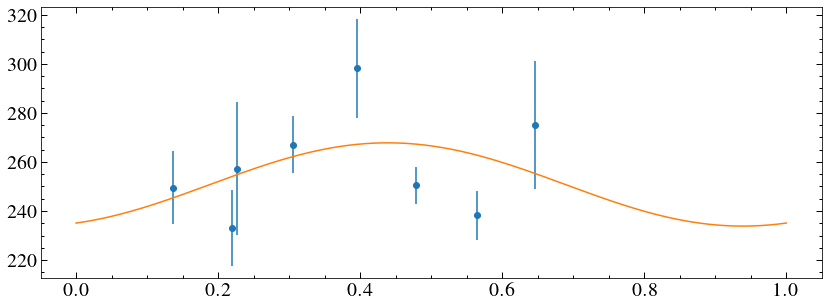

In [128]:
#https://academic.oup.com/mnras/article/493/1/126/5735996?login=true
p = 0.7668944 #d
g = 39.0931 
ge = 0.0057
k = 0.5949
keu = 0.0077
ked = 0.0063




tfold = mjds/p % 1
plt.errorbar(tfold, dvs, yerr= [dveus, dvels], marker='o', ls='none')

orbit = models.Sine1D(k, 1, phase=0.5, bounds=dict(amplitude=[k-ked, k+keu]), fixed=dict(frequency=True))+models.Const1D(g)#, bounds=dict(amplitude=[g-ge, g+ge]))
orbit = models.Sine1D(k, 1, fixed=dict(frequency=True))+models.Const1D(g)#, bounds=dict(amplitude=[g-ge, g+ge]))
orbfit = fitter(orbit, tfold, dvs, maxiter=10000)

tmod = np.linspace(0, 1, 1000)
plt.plot(tmod, orbfit(tmod))
orbfit

No.

In [129]:
import prepare_phoenix_svo as pp


In [131]:
1000/3.8713694898542497

258.3065250218853

In [143]:
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.696
# teff = 5715
teff = 4400
# radius = 1.79
radius = 0.697
distance = (1000/3.8713694898542497)
save_path = 'models/'
star = 'NGTS_10'
g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
print(np.log10(g.value))
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
normfac = ((radius*R)/(distance*u.pc.to(u.m)))**2

4.594211310717677


In [133]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

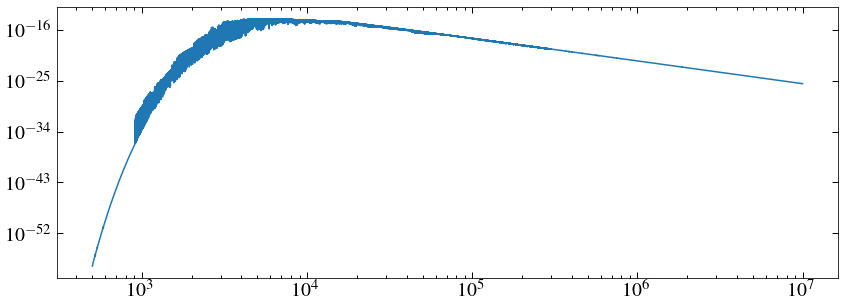

In [144]:
plt.plot(pw, pf*normfac)
plt.yscale('log')
plt.xscale('log')

In [149]:
nw, nf, ne = wn, fn, en #oops
ow, of, oe = wo, fo, eo 

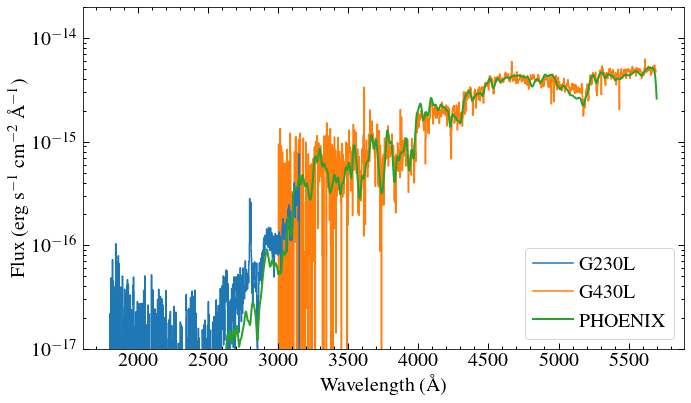

In [167]:
pmask = (pw > 1900) & (pw < 5700)
pwi, pfi = pw[pmask], pf[pmask]*normfac*0.7
pwi, pfi = smear(pwi, pfi, 500)
plt.figure(figsize=(10, 6))
plt.step(nw[nw > 1800], nf[nw > 1800], where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=4)

# plt.title('WASP-63')
# plt.xlim(1980, 5650)
plt.ylim(1e-17, 2e-14)
plt.tight_layout()


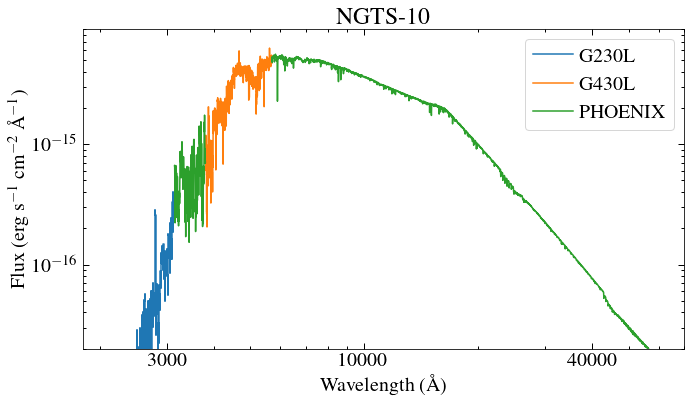

In [182]:
pwi, pfi = smear(pw, pf, 2000)
pmask = (pwi > 1800) & (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac*0.7

fig, axes = plt.subplots(figsize=(10,6))
# gs = GridSpec(4, 1, figure=fig)
# plt.subplot(gs[0:3])
nmask = (nw > 2500) & (nf > 0) & (nw < 3140) 
plt.step(nw[nmask], nf[nmask], where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow[(ow > 3800)], of[(ow > 3800)], where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
pmask2 = (pwi > nw[-1]) & (pwi < 3800) 
plt.plot(pwi[pmask2], pfi[pmask2], label= 'PHOENIX')
pmask3 = pwi > ow[-1] 
plt.plot(pwi[pmask3], pfi[pmask3], c='C2')
# plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
plt.legend(frameon=True, loc=1)
plt.title('NGTS-10')
plt.xlim(1800, 70000)
plt.ylim(2e-17, 9e-15)
plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/NGTS-10_ql.png', facecolor= 'w')